In [1]:
import numpy as np
import math
import torch
import sys
from matplotlib import pyplot as plt
from matplotlib import colors as clrs

/home/arnav/miniconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if sys.platform == "darwin":
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Q 3.1

### Logistic Regression

In [3]:
# Create dataloaders
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, i):
        return self.data[i], self.labels[i]

class LinearLogisticRegression(torch.nn.Module):
    def __init__(self):
        super(LinearLogisticRegression, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(2, 1, bias=True),
            torch.nn.Sigmoid()
        )
        self.layers[0].state_dict()['weight'].zero_()
        return
    def forward(self, x):
        x = x.view(-1, 2)
        return self.layers(x)

class KernelLogisticRegression(torch.nn.Module):
    def __init__(self):
        super(LinearLogisticRegression, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(4, 1, bias=True),
            torch.nn.Sigmoid()
        )
        self.layers[0].state_dict()['weight'].zero_()
        return
    def forward(self, x):
        x = x.view(-1, 4)
        return self.layers(x)

class LinearSVM(torch.nn.Module):
    def __init__(self):
        super(LinearSVM, self).__init__()
        self.layers = torch.nn.Sequential(torch.nn.Linear(2, 1, bias=True))
        return

    def weights(self):
        return self.layers[0].state_dict()['weight']

    def forward(self, x):
        x = x.view(-1, 2)
        return self.layers(x)

class KernelSVM(torch.nn.Module):
    def __init__(self):
        super(KernelSVM, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(4, 1, bias=True),
            torch.nn.Sigmoid()
        )
        self.layers[0].state_dict()['weight'].zero_()
        return
    def forward(self, x):
        x = x.view(-1, 4)
        return self.layers(x)

def run_knn(k, X_train, Y_train, X_test):
    distances = -2*(X_test@X_train.T) + \
                torch.sum(torch.square(X_train), axis=1) + \
                torch.sum(torch.square(X_test), axis=1).unsqueeze_(-1)
    sorted_indices = torch.argsort(distances, axis = 1)[:, :k]
    knn = Y_train[sorted_indices].astype(np.int32)
    return knn

## Q 3.2

In [4]:
# Create Dataset
mu = torch.tensor([2.5, 0])
a  = []
b = []
positive_example_sampler = torch.distributions.MultivariateNormal(mu, torch.eye(2))
negative_example_sampler = torch.distributions.MultivariateNormal(-mu, torch.eye(2))
for _ in range(750):
    a.append(positive_example_sampler.sample().view(1,2))
    b.append(negative_example_sampler.sample().view(1,2))

postive_data_points = torch.stack(a).view(750, 2)
negative_data_points = torch.stack(b).view(750, 2)

In [5]:
data_set = torch.cat((postive_data_points, negative_data_points))
labels = torch.cat((torch.ones(750, 1), torch.zeros(750, 1)))
shuffle_index = torch.randperm(data_set.shape[0])
data_set = data_set[shuffle_index]
labels = labels[shuffle_index]

In [6]:
permuted_indices = torch.randperm(data_set.shape[0])
training_data = data_set[permuted_indices[:1000]]
training_labels = labels[permuted_indices[:1000]]
validation_data = data_set[permuted_indices[1000:1250]]
validation_labels = labels[permuted_indices[1000:1250]]
test_data = data_set[permuted_indices[1250:1500]]
test_labels = labels[permuted_indices[1250:1500]] 

training_set = Dataset(training_data, training_labels)
train_loader = torch.utils.data.DataLoader(training_set, shuffle=True, batch_size=256)
validation_set = Dataset(validation_data, validation_labels)
validation_loader = torch.utils.data.DataLoader(validation_set, shuffle=True, batch_size=250)
test_set = Dataset(test_data, test_labels)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=250)

In [16]:
def get_prediction(model, data):
    return model(data).detach()

def get_accuracy(predictions, labels):
    threshold = torch.tensor([0.5])
    predictions = (predictions >= threshold).float()*1
    return float(torch.count_nonzero((labels == predictions)))/float(len(labels))

def report_acc_decision_boundary(model, test_set_loader):
    for data, labels in test_set_loader:
        predictions = get_prediction(model, data)
        accuracy = get_accuracy(predictions, labels)
        print(f" Accuracy of model on test set: {accuracy*100}%")
    return

def draw_decision_boundary(model, test_dataset):
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes()

    x_min, x_max = test_set.data.min() - 1, test_set.data.max() + 1
    y_min, y_max = test_set.data.min() - 1, test_set.data.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01).astype(np.float32),
                        np.arange(y_min, y_max, 0.01).astype(np.float32))
    preds = get_prediction(model, torch.hstack((torch.from_numpy(xx.ravel()).view(len(xx.ravel()), 1), torch.from_numpy(yy.ravel()).view(len(xx.ravel()), 1))))
    threshold = torch.tensor([0.5])
    preds = (preds >= threshold).float()*1
    preds = preds.reshape(xx.shape)
    plt.contourf(xx, yy, preds, cmap='Paired_r', alpha=0.5)
    plt.contour(xx, yy, preds, colors='k', linewidths=0.7)

    ax.scatter(test_dataset.data[:, 0], test_dataset.data[:, 1], c=test_dataset.labels ,cmap = clrs.ListedColormap(["red", "blue"]))
    plt.title("Decision Boundary")

    plt.show()
    return

def train_logistic_regression(model, train_loader, validation_loader, learning_rate, losses, debug=False):
    criterion = torch.nn.BCELoss(reduction='mean')
    threshold = 1e-4
    loss_reduction = 1.0
    optim = torch.optim.SGD(model.parameters(), learning_rate)
    prev_loss = math.inf
    curr_loss = math.inf
    epoch = 1

    while loss_reduction >= threshold:
        for x, y in train_loader:
            # Train model on training set
            y_hat = model(x)
            loss = criterion(y_hat, y)
            optim.zero_grad()
            loss.backward()
            optim.step()

            # Evaluate on validation set
        for val_data, val_labels in validation_loader:
            val_predictions = get_prediction(model, val_data)
            curr_loss = criterion(val_predictions, val_labels).item()
        loss_reduction = abs(curr_loss/prev_loss - 1.0)
        prev_loss = curr_loss
        losses.append(prev_loss)

        if debug:
            print(f"Loss reduction after {epoch} epochs: {loss_reduction}")
        epoch += 1
    return

def train_linear_svm(model, train_loader, validation_loader, learning_rate, reg_param, losses, debug=False):
    threshold = 1e-4
    loss_reduction = 1.0
    optim = torch.optim.SGD(model.parameters(), learning_rate)
    prev_loss = math.inf
    curr_loss = math.inf
    
    epoch = 1
    while loss_reduction >= threshold:
        for x, y in train_loader:
            # Train model on training set
            y_hat = model(x).view(x.shape[0], 1)
            #Get weights of the linear layer
            params = model.weights()
            loss = torch.sum(y*torch.max(torch.FloatTensor([0]), 1 - y_hat) + (1 - y)*torch.max(torch.FloatTensor([0]), 1 + y_hat)) + 0.5*reg_param*torch.sum(torch.square(params))
            optim.zero_grad()
            loss.backward()
            optim.step()

            # Evaluate on validation set
        for val_data, val_labels in validation_loader:
            val_predictions = get_prediction(model, val_data).view(val_data.shape[0], 1)
            curr_loss = (torch.sum(val_labels*torch.max(torch.FloatTensor([0]), 1 - val_predictions) + (1 - val_labels)*torch.max(torch.FloatTensor([0]), 1 + val_predictions)) + 0.5*reg_param*torch.sum(torch.square(params))).item()
        loss_reduction = abs(curr_loss/prev_loss - 1.0)
        prev_loss = curr_loss
        losses.append(prev_loss)
        if debug:
            print(f"Loss reduction after {epoch} epochs: {loss_reduction}")
        epoch += 1
    return


#### Logistic Regression - Report Accuracy and draw Decision Boundary

In [8]:
# Train model
linear_lr_model = LinearLogisticRegression()
losses = []
train_logistic_regression(linear_lr_model, train_loader, validation_loader, 0.05, losses)

 Accuracy of model on test set: 99.2%


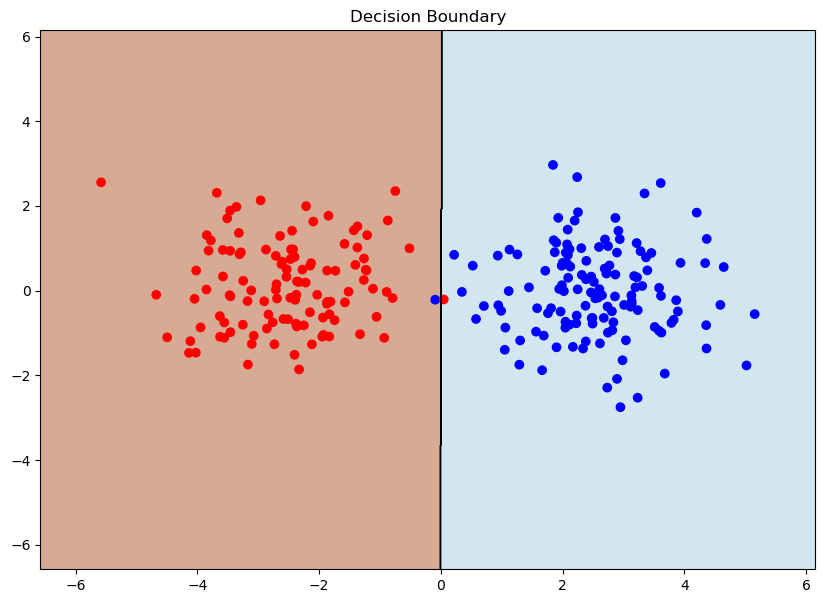

In [9]:
#Report Accuracy
report_acc_decision_boundary(linear_lr_model, test_loader)

#Draw - decision boundary
draw_decision_boundary(linear_lr_model, test_set)

#### Linear SVM

In [10]:
linear_svm_model = LinearSVM()
losses = []
reg_param = 1/3
step_size = 0.0075
train_linear_svm(linear_svm_model, train_loader, validation_loader, step_size, reg_param, losses)


Loss reduction after 1 epochs: 1.0
Loss reduction after 2 epochs: 0.014833747303081068
Loss reduction after 3 epochs: 0.015056430632217621
Loss reduction after 4 epochs: 0.0152864561193502
Loss reduction after 5 epochs: 0.015523206830907244
Loss reduction after 6 epochs: 0.011984189647892829
Loss reduction after 7 epochs: 0.012127564240486333
Loss reduction after 8 epochs: 0.012274722499004853
Loss reduction after 9 epochs: 0.013766751051118353
Loss reduction after 10 epochs: 0.013955599462452062
Loss reduction after 11 epochs: 0.0141496722651262
Loss reduction after 12 epochs: 0.01434949502433025
Loss reduction after 13 epochs: 0.01455516613901875
Loss reduction after 14 epochs: 0.01476655313350439
Loss reduction after 15 epochs: 0.014984540791954992
Loss reduction after 16 epochs: 0.013756118223649527
Loss reduction after 17 epochs: 0.010224790579308474
Loss reduction after 18 epochs: 0.006534273525595546
Loss reduction after 19 epochs: 0.006573431300248345
Loss reduction after 20 ep

 Accuracy of model on test set: 99.6%


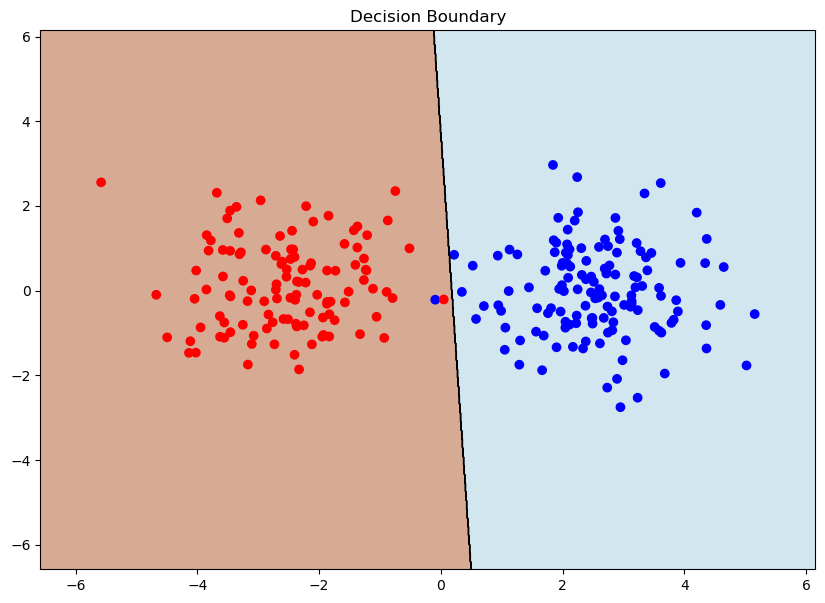

In [11]:
#Report Accuracy
report_acc_decision_boundary(linear_svm_model, test_loader)

#Draw - decision boundary
draw_decision_boundary(linear_svm_model, test_set)

### Naives Bayes Classifier

In [30]:
from sklearn.naive_bayes import GaussianNB

naive_bayes_model = GaussianNB()
naive_bayes_model.fit(training_data, training_labels)
val_predictions = naive_bayes_model.predict(validation_data)

print("Number of mislabeled points out of a total %d points : %d"   % (validation_data.shape[0], torch.count_nonzero(torch.where(validation_labels != torch.from_numpy(val_predictions).view(-1, 1), validation_labels, torch.from_numpy(val_predictions).view(-1, 1)))))


Number of mislabeled points out of a total 250 points : 124


/home/arnav/miniconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Q 3.3

In [12]:
from sklearn import datasets

In [13]:
data_set_tuples = datasets.make_circles(1500)

data_set = torch.zeros((len(data_set_tuples[0]), 2), dtype=torch.float)
labels = torch.zeros((len(data_set_tuples[0]), 1), dtype=torch.float)
data_set.copy_(torch.from_numpy(data_set_tuples[0].astype(np.float32)))
labels.copy_(torch.from_numpy(data_set_tuples[1].astype(np.float32)).view((len(data_set_tuples[0]), 1)))
permuted_indices = torch.randperm(data_set.shape[0])
training_data = data_set[permuted_indices[:1000]]
training_labels = labels[permuted_indices[:1000]]
validation_data = data_set[permuted_indices[1000:1250]]
validation_labels = labels[permuted_indices[1000:1250]]
test_data = data_set[permuted_indices[1250:1500]]
test_labels = labels[permuted_indices[1250:1500]]

training_set = Dataset(training_data, training_labels)
train_loader = torch.utils.data.DataLoader(training_set, shuffle=True, batch_size=256)
validation_set = Dataset(validation_data, validation_labels)
validation_loader = torch.utils.data.DataLoader(validation_set, shuffle=True, batch_size=250)
test_set = Dataset(test_data, test_labels)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=250)

#### Linear Regression Model

 Accuracy of model on test set: 55.60000000000001%


/tmp/ipykernel_25606/524283025.py:29: UserWarning: No contour levels were found within the data range.
  plt.contour(xx, yy, preds, colors='k', linewidths=0.7)


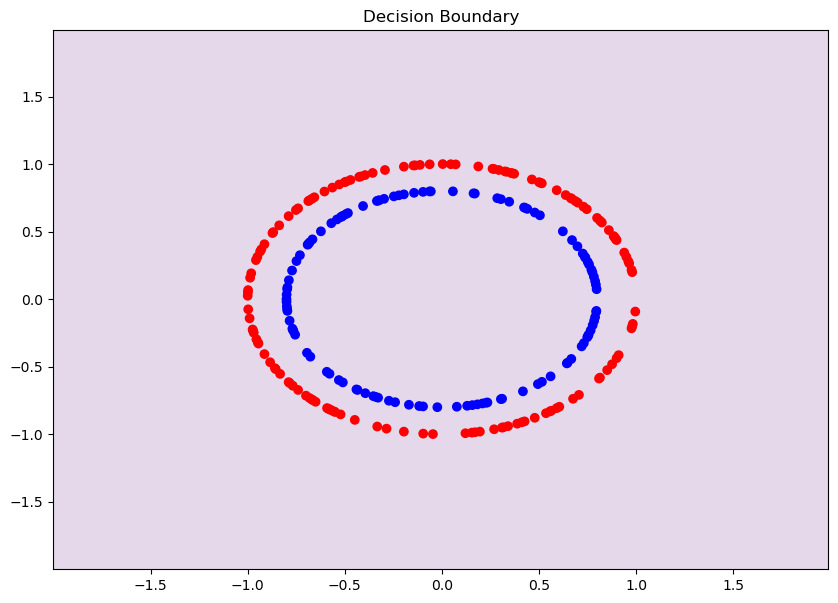

In [14]:
linear_lr_model = LinearLogisticRegression()
losses = []
train_logistic_regression(linear_lr_model, train_loader, validation_loader, 0.05, losses)

#Accuracy
report_acc_decision_boundary(linear_lr_model, test_loader)

#Decision Boundary
draw_decision_boundary(linear_lr_model, test_set)

#### Linear SVM Model

Loss reduction after 1 epochs: 1.0
Loss reduction after 2 epochs: 0.010710321941805212
Loss reduction after 3 epochs: 0.010619749640008225
Loss reduction after 4 epochs: 0.010531074790044226
Loss reduction after 5 epochs: 0.0009987529945887363
Loss reduction after 6 epochs: 0.00160152657748025
Loss reduction after 7 epochs: 0.001833839671293247
Loss reduction after 8 epochs: 0.0022750543539493684
Loss reduction after 9 epochs: 0.002941201690976558
Loss reduction after 10 epochs: 0.013206414402764821
Loss reduction after 11 epochs: 0.00598692176944704
Loss reduction after 12 epochs: 0.0043655469444271455
Loss reduction after 13 epochs: 0.011524140988178666
Loss reduction after 14 epochs: 0.0009288808857350617
Loss reduction after 15 epochs: 0.014430901187662215
Loss reduction after 16 epochs: 0.013066258988679191
Loss reduction after 17 epochs: 0.0019996278052047955
Loss reduction after 18 epochs: 0.0033511175758126344
Loss reduction after 19 epochs: 0.00662714151639654
Loss reduction a

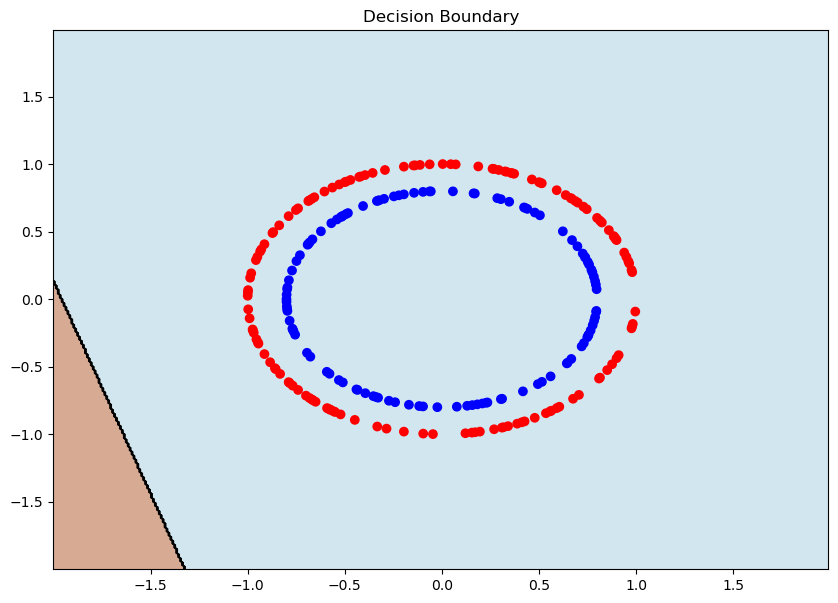

In [15]:
linear_svm_model = LinearSVM()
losses = []
reg_param = 1/3
train_linear_svm(linear_svm_model, train_loader, validation_loader, 0.0075, reg_param, losses)

#Accuracy
report_acc_decision_boundary(linear_svm_model, test_loader)

#Decision Boundary
draw_decision_boundary(linear_svm_model, test_set)